In [1]:
import cv2,os
import numpy as np
from matplotlib import pyplot as plt
import torch
import torchvision.models as models
import torch.nn as nn
from torchvision import transforms
from tqdm import tqdm_notebook as tqdm
from PIL import Image
from tqdm import tqdm

from torch.nn import functional as F
from collections import OrderedDict
import math
device = "cuda"

# Load Model and Data

In [5]:
Data_01Nami=np.load("data/imread_02Namix40.npy",allow_pickle=True)
Data_00=np.load("data/imread_01x40.npy",allow_pickle=True)
print("Data_01.shape:", Data_00.shape)
print("Data_02Nami.shape:", Data_01Nami.shape)

Data_01.shape: (11990,)
Data_02Nami.shape: (1738,)


In [6]:
def pad(img,Max_shape_0,Max_shape_1):
    imgSize = img.shape
    top_size,bottom_size = (Max_shape_0-imgSize[0])//2,(Max_shape_0-imgSize[0])//2
    left_size,right_size = (Max_shape_1-imgSize[1])//2,(Max_shape_1-imgSize[1])//2
    if (imgSize[0] % 2) != 0:
        top_size,bottom_size = (Max_shape_0-imgSize[0])//2,(Max_shape_0-imgSize[0])//2+1
    if (imgSize[1] % 2) != 0:     
        left_size,right_size = (Max_shape_1-imgSize[1])//2,(Max_shape_1-imgSize[1])//2+1
    imgpad = cv2.copyMakeBorder(img,top_size,bottom_size,left_size,right_size,cv2.BORDER_CONSTANT,value=(0,0,0))
    return top_size,bottom_size,left_size,right_size,imgpad,imgSize

# GradCAM

In [20]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50

def gradcamX(model,target_layers,imgpad,input_tensor,true_y):
    # Note: input_tensor can be a batch tensor with several images!
    # predict label
    model.eval()
    output = model(input_img)
    pre_y = output.argmax(1).cpu().item()
    print("Prediction label: ", pre_y==true_y)
    print("Real: ",true_y,";   Predict: ", pre_y)
    
    # Construct the CAM object once, and then re-use it on many images:
    cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)

    # You can also use it within a with statement, to make sure it is freed,
    # In case you need to re-create it inside an outer loop:
    # with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
    #   ...

    # We have to specify the target we want to generate
    # the Class Activation Maps for.
    # If targets is None, the highest scoring category
    # will be used for every image in the batch.
    # Here we use ClassifierOutputTarget, but you can define your own custom targets
    # That are, for example, combinations of categories, or specific outputs in a non standard model.
    targets = None
    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    # In this example grayscale_cam has only one image in the batch:
    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(imgpad, grayscale_cam, use_rgb=True)
    plt.imshow(visualization)
    plt.show()

# Discussion

Prediction label:  False
Real:  0 ;   Predict:  1


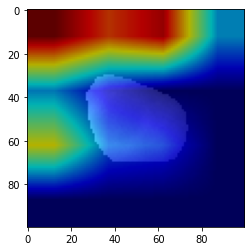

Prediction label:  True
Real:  0 ;   Predict:  0


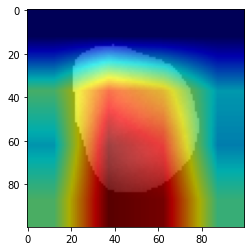

Prediction label:  False
Real:  0 ;   Predict:  1


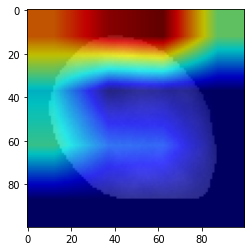

Prediction label:  False
Real:  0 ;   Predict:  1


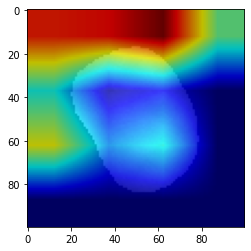

Prediction label:  True
Real:  0 ;   Predict:  0


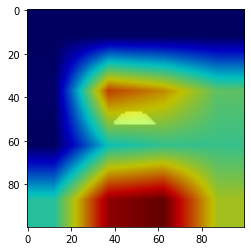

Prediction label:  True
Real:  0 ;   Predict:  0


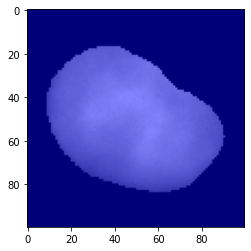

Prediction label:  True
Real:  0 ;   Predict:  0


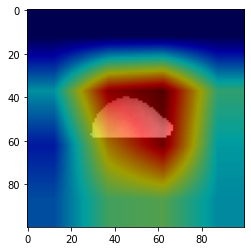

Prediction label:  True
Real:  0 ;   Predict:  0


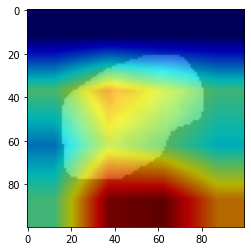

Prediction label:  True
Real:  0 ;   Predict:  0


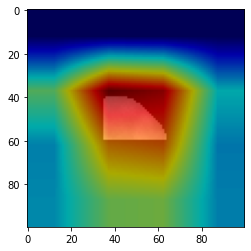

Prediction label:  True
Real:  0 ;   Predict:  0


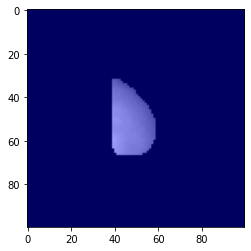

In [34]:
# load model
model = torch.load("SelfResnet18.pkl")
target_layers = [model.layer4[0].conv1]
true_y = 0

for i in range(10):
    img=Data_00[50*i]
    t,b,r,l,imgpad,imgSize = pad(img,100,100)
    imgpad = np.float32(imgpad)/255

    transform = transforms.Compose([transforms.ToTensor()])
    input_img = transform(imgpad).unsqueeze(0).to(device)

    gradcamX(model,target_layers,imgpad,input_img,true_y)

Prediction label:  True
Real:  0 ;   Predict:  0


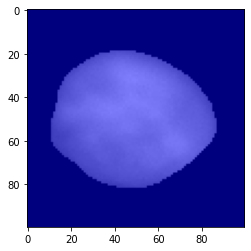

In [29]:
img=Data_00[900]
t,b,r,l,imgpad,imgSize = pad(img,100,100)
imgpad = np.float32(imgpad)/255
transform = transforms.Compose([transforms.ToTensor()])
input_img = transform(imgpad).unsqueeze(0).to(device)

model = torch.load("SelfResnet18.pkl")
model.eval()
output = model(input_img)
true_y = 0
pre_y = output.argmax(1).cpu().item()
print("Prediction label: ", pre_y==true_y)
print("Real: ",true_y,";   Predict: ", pre_y)

target_layers = [model.layer1]
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
targets = None
input_tensor = input_img
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(imgpad, grayscale_cam, use_rgb=True)
plt.imshow(visualization)
plt.show()